Import all the libraries


In [1]:
import time
import warnings
from itertools import cycle, islice
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.decomposition import PCA






Set up cluster parameters

In [2]:
# Set up cluster parameters
default_base = {
    "quantile": .3,
    "eps": .3,
    "damping": .9,
    "preference": -200,
    "n_neighbors": 1,
    "n_clusters": 5,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

# Update parameters with your specific values if needed
params = default_base.copy()

Get the newest data 

In [3]:
# Get data
def GetNewestDataFileNamer(x):
    #Check for env variable - error if not present
    envP7RootDir = os.getenv("P7RootDir")
    if envP7RootDir is None:
        print("---> If you are working in vscode\n---> you need to restart the aplication\n---> After you have made a env\n---> for vscode to see it!!")
        print("---> You need to make a env called 'P7RootDir' containing the path to P7 root dir")
        raise ValueError('Environment variable not found (!env)')
    
    if x == 'labeled':
        #Enter CSV directory, change the directory for labeled data and unlabeled data
        workDir = envP7RootDir + "\\Data\\CSV files"
    else:
        workDir = envP7RootDir + "\\Data\\Refined data\\Unlabeled data\\PROCESSED DATA"
    
    #Find all dates from the files
    dirDates = []
    for file in os.listdir(workDir):
        onlyDate = re.findall(r'\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}', file)
        new_string = str(onlyDate).replace("-", "")
        new_string = new_string.replace("_","")
        new_string = new_string.strip("[]'")
        dirDates.append([int(new_string),file])
    
    #Sort dates and return newest
    dirDates = sorted(dirDates,key=lambda l:l[1],reverse=True) # Take oldest data first i belive 
    return(workDir + "\\" + dirDates[0][1])
NewestDataFileName = GetNewestDataFileNamer('labeled')



Read the CSV file

In [4]:
df = pd.read_csv(NewestDataFileName)

data = df.drop(['Filename','Label'], axis=1)
labels = df['Label']


# Scale the data to have 0 mean and variance 1 - recommended step by sklearn
X = StandardScaler().fit_transform(data)

# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=10).fit(data)
X = pca.transform(data)

# Estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

# Connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params["n_neighbors"], include_self=False
)
# Make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

Define Clustering Algorithms

In [5]:
# Create cluster objects
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(
    n_clusters=params["n_clusters"],
    random_state=params["random_state"],
)
ward = cluster.AgglomerativeClustering(
    n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
)
spectral = cluster.SpectralClustering(
    n_clusters=params["n_clusters"],
    eigen_solver="arpack",
    affinity="nearest_neighbors",
    random_state=params["random_state"],
)
dbscan = cluster.DBSCAN(eps=params["eps"])
hdbscan = cluster.HDBSCAN(
    min_samples=params["hdbscan_min_samples"],
    min_cluster_size=params["hdbscan_min_cluster_size"],
    allow_single_cluster=params["allow_single_cluster"],
)
optics = cluster.OPTICS(
    min_samples=params["min_samples"],
    xi=params["xi"],
    min_cluster_size=params["min_cluster_size"],
)
affinity_propagation = cluster.AffinityPropagation(
    damping=params["damping"],
    preference=params["preference"],
    random_state=params["random_state"],
)
average_linkage = cluster.AgglomerativeClustering(
    linkage="average",
    metric="cityblock",
    n_clusters=params["n_clusters"],
    connectivity=connectivity,
)
birch = cluster.Birch(n_clusters=params["n_clusters"])
gmm = mixture.GaussianMixture(
    n_components=params["n_clusters"],
    covariance_type="full",
    random_state=params["random_state"],
)

clustering_algorithms = (
    ("MiniBatch\nKMeans", two_means),
    ("Affinity\nPropagation", affinity_propagation),
    ("MeanShift", ms),
    ("Spectral\nClustering", spectral),
    ("Ward", ward),
    ("Agglomerative\nClustering", average_linkage),
    ("DBSCAN", dbscan),
    ("HDBSCAN", hdbscan),
    ("OPTICS", optics),
    ("BIRCH", birch),
    ("Gaussian\nMixture", gmm),
)

Plot Each Clustering Algorithm

In [6]:
def plot_clustering(algorithm, name, X):
    t0 = time.time()

    # Catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the "
            + "connectivity matrix is [0-9]{1,2}"
            + " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning,
        )
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding"
            + " may not work as expected.",
            category=UserWarning,
        )
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, "labels_"):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)

    plt.figure(figsize=(6, 6))
    plt.title(name, size=18)

    colors = np.array(
        list(
            islice(
                cycle(
                    [
                        "#377eb8",
                        "#ff7f00",
                        "#4daf4a",
                        "#f781bf",
                        "#a65628",
                        "#984ea3",
                        "#999999",
                        "#e41a1c",
                        "#dede00",
                    ]
                ),
                int(max(y_pred) + 1),
            )
        )
    )
    # Add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(np.min(X[:, 0]), np.max(X[:, 0]))
    plt.ylim(np.min(X[:, 1]), np.max(X[:, 1]))
    plt.text(
        0.99,
        0.01,
        ("%.2fs" % (t1 - t0)).lstrip("0"),
        transform=plt.gca().transAxes,
        size=15,
        horizontalalignment="right",
    )
    plt.show()

Algorithm: MiniBatch
KMeans
Adjusted Rand Index: 0.6004063404106341
Silhouette Score: 0.418064866508623
------------------------------


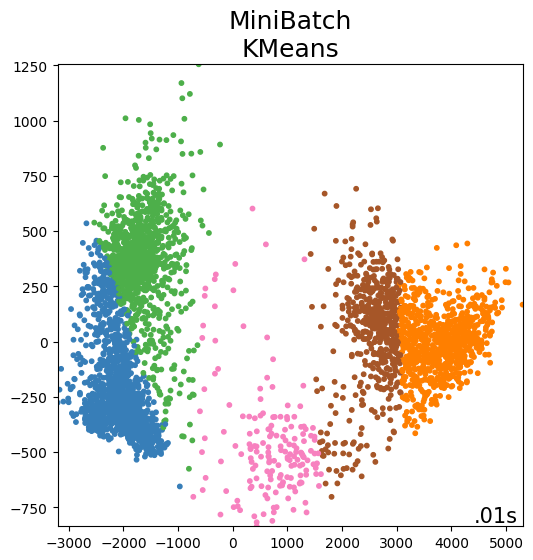

Algorithm: Spectral
Clustering
Adjusted Rand Index: 0.7415866223953762
Silhouette Score: 0.40948150706564396
------------------------------


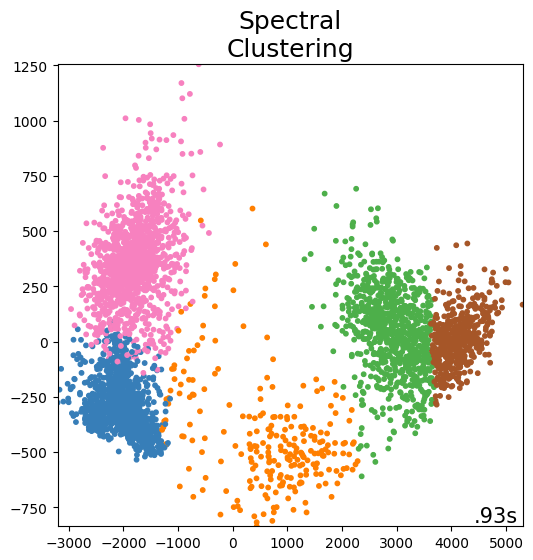

Algorithm: DBSCAN
Adjusted Rand Index: 0.0
Silhouette Score: -1
------------------------------


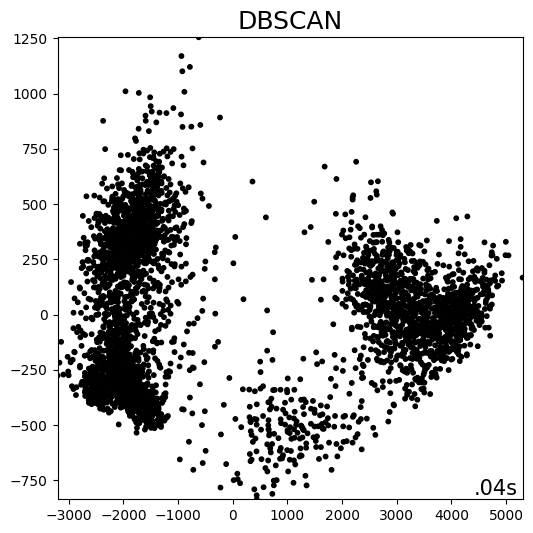

Algorithm: BIRCH
Adjusted Rand Index: 0.3926415257851073
Silhouette Score: 0.386675609748479
------------------------------


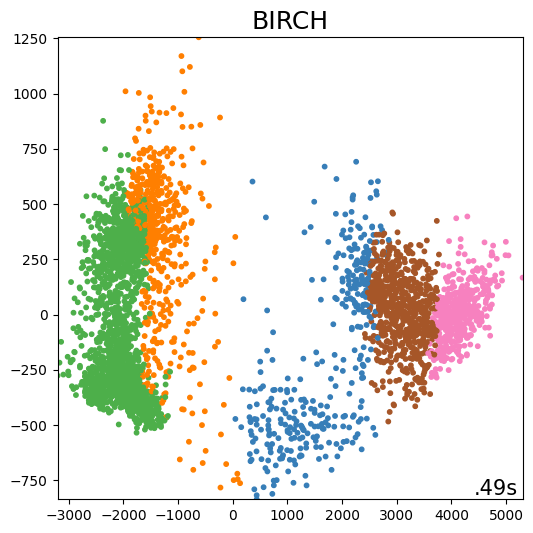

Algorithm: Gaussian
Mixture
Adjusted Rand Index: 0.7771783291873291
Silhouette Score: 0.3066776775055374
------------------------------


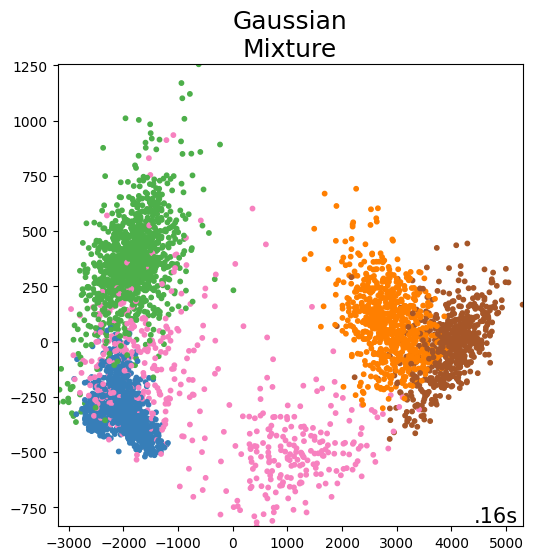

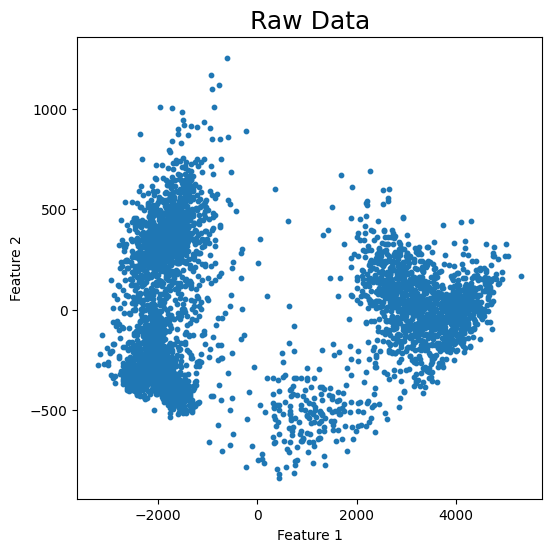

In [7]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Assuming y_true contains the true labels for the data
y_true = labels

# Function to evaluate clustering performance
def evaluate_clustering(y_true, y_pred):
    ari = adjusted_rand_score(y_true, y_pred)
    if len(set(y_pred)) > 1:  # Check if there is more than one cluster
        sil = silhouette_score(X, y_pred, metric='euclidean')
    else:
        sil = -1  # Assign a default value if only one cluster is found
    return ari, sil

# Iterate over the clustering algorithms and evaluate their performance
for name, algorithm in clustering_algorithms:
    if name in ['MiniBatch\nKMeans', 'Spectral\nClustering', 'DBSCAN', 'BIRCH', 'Gaussian\nMixture']:
        algorithm.fit(X)
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)
        
        # Evaluate the clustering performance
        ari, sil = evaluate_clustering(y_true, y_pred)
        print(f"Algorithm: {name}")
        # Compare the clustering results of how much together or apart the true and anticipated labels are
        print(f"Adjusted Rand Index: {ari}")
        # The coheviseness and seperation of the clusters are measured range from -1 to 1, with 1 
        # indicating dense, well-separated clusters and -1 indicating objects might be in incorrect clusters
        print(f"Silhouette Score: {sil}")
        print("-" * 30)

        # Plot the clustering results
        plot_clustering(algorithm, name, X)

# Plot the raw data
plt.figure(figsize=(6, 6))
plt.title("Raw Data", size=18)
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()